# Setting up data

### Mounting Google Drive

In [15]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# path where all the data is and will be stored
BASE_DIR = "drive/MyDrive/Brain Tumor/Data"

### Reading in the metadata

In [4]:
import pandas as pd
metadata = pd.read_csv(os.path.join(BASE_DIR, "metadata_rgb_only.csv"))
# only doing JPEG images
metadata = metadata.loc[metadata["format"] == "JPEG"]
metadata.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
5,6,Cancer (1000).jpg,tumor,JPEG,RGB,"(290, 250, 3)"
6,7,Cancer (1001).jpg,tumor,JPEG,RGB,"(620, 620, 3)"


### Plotting how the data is split between classes

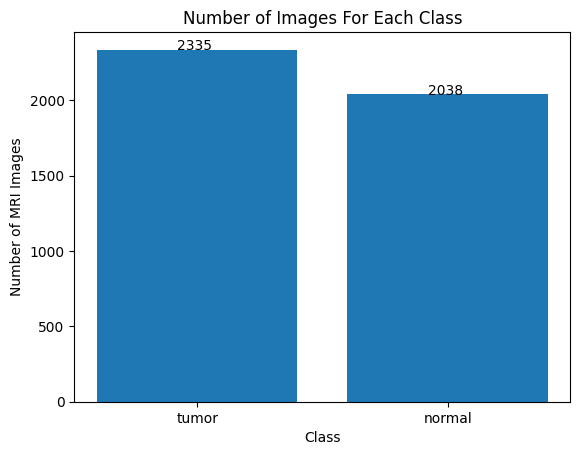

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
counts = metadata["class"].value_counts()
bars = plt.bar(counts.keys(), counts)

# to show the number of images within the graph
for bar in bars:
    xval = bar.get_x() + (bar.get_width() / 2) - 0.08
    yval = bar.get_height()
    plt.text(xval, yval, yval)
plt.title("Number of Images For Each Class")
plt.xlabel("Class")
plt.ylabel("Number of MRI Images")
plt.show()

### Splitting data into training and testing

In [6]:
from sklearn.model_selection import train_test_split
# splitting into healthy and tumorous (only taking "image" and "class" columns)
healthy = metadata[metadata["class"] == "normal"][["image", "class"]]
tumorous = metadata[metadata["class"] == "tumor"][["image", "class"]]

# splitting the healthy into training and testing (80/20 split)
healthy_train, healthy_test = train_test_split(healthy, test_size=0.2, random_state=13)
# splitting the tumorous into training and testing (80/20 split)
tumorous_train, tumorous_test = train_test_split(tumorous, test_size=0.2, random_state=14)

### Creating folders for training and testing data

In [ ]:
parent_folders = ["test", "train"]
subfolders = ["healthy", "tumorous"]
for p_fold in parent_folders:
    os.makedirs(os.path.join(BASE_DIR, p_fold))
    for subfold in subfolders:
        os.makedirs(os.path.join(BASE_DIR, p_fold, subfold))

### Copying images from the folder structure in the raw data to the new folder structure

In [8]:
import shutil
# healthy train
for index, row in healthy_train.iterrows():
    shutil.copy(os.path.join(BASE_DIR, "Images/Healthy", row["image"]),
                os.path.join(BASE_DIR, "train/healthy", row["image"]))

# healthy test
for index, row in healthy_test.iterrows():
    shutil.copy(os.path.join(BASE_DIR, "Images/Healthy", row["image"]),
                os.path.join(BASE_DIR, "test/healthy", row["image"]))

# tumorous train
for index, row in tumorous_train.iterrows():
    shutil.copy(os.path.join(BASE_DIR, "Images/Cancerous", row["image"]),
                os.path.join(BASE_DIR, "train/tumorous", row["image"]))

# tumorous test
for index, row in tumorous_test.iterrows():
    shutil.copy(os.path.join(BASE_DIR, "Images/Cancerous", row["image"]),
                os.path.join(BASE_DIR, "test/tumorous", row["image"]))

train_healthy_dir = os.path.join(BASE_DIR, "train/healthy")
test_healthy_dir = os.path.join(BASE_DIR, "test/healthy")
train_tumor_dir = os.path.join(BASE_DIR, "train/tumorous")
test_tumor_dir = os.path.join(BASE_DIR, "test/tumorous")

print("total training healthy images:", len(os.listdir(train_healthy_dir)))
print("total testing healthy images:", len(os.listdir(test_healthy_dir)))
print("total training tumor images:", len(os.listdir(train_tumor_dir)))
print("total testing tumor images:", len(os.listdir(test_tumor_dir)))

total training healthy images: 1630
total testing healthy images: 408
total training tumor images: 1868
total testing tumor images: 467


### Example images

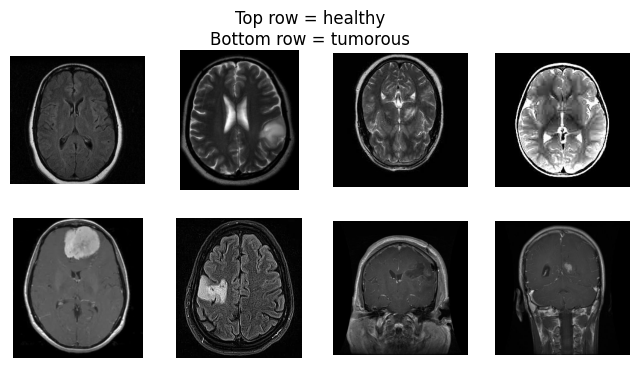

In [9]:
import matplotlib.pyplot as plt
from matplotlib import image

# number of rows and columns to be shown in the graphic
numrows = 2
numcols = 4
fig = plt.gcf()
#set the figure size
fig.set_size_inches(numcols * 2, numrows * 2)

# get the full file path for the first four files in the train_healthy directory and the train_tumor directory
healthy_pix = [os.path.join(train_healthy_dir, filename) for filename in os.listdir(train_healthy_dir)[0:4]]
tumor_pix = [os.path.join(train_tumor_dir, filename) for filename in os.listdir(train_tumor_dir)[0:4]]

for i, img_path in enumerate(healthy_pix+tumor_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(numrows, numcols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = image.imread(img_path)
    plt.imshow(img)

# the first four read in are healthy so the top row is healthy, and bottom is tumorous
plt.suptitle("Top row = healthy\nBottom row = tumorous")
plt.show()

# Building the model

In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
# first convolution and maxpool
model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(256,256,3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# second convolution and maxpool
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# third convolution and maxpool
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [4]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])

# Preparing images to train and test model

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(BASE_DIR, "train"),
                                                    target_size=(256, 256),
                                                    batch_size=64,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(os.path.join(BASE_DIR, "test"),
                                                    target_size=(256, 256),
                                                    batch_size=64,
                                                    class_mode='binary')

Found 3498 images belonging to 2 classes.
Found 875 images belonging to 2 classes.


# Training

In [6]:
history = model.fit(train_generator, epochs=5, validation_data=val_generator, verbose=1)

Epoch 1/5
55/55 [==============================] - 1565s 29s/step - loss: 0.8509 - acc: 0.6498 - val_loss: 0.5961 - val_acc: 0.7154
Epoch 2/5
55/55 [==============================] - 628s 11s/step - loss: 0.4474 - acc: 0.8007 - val_loss: 0.2942 - val_acc: 0.8617
Epoch 3/5
55/55 [==============================] - 586s 11s/step - loss: 0.3179 - acc: 0.8676 - val_loss: 0.2627 - val_acc: 0.8731
Epoch 4/5
55/55 [==============================] - 589s 11s/step - loss: 0.1948 - acc: 0.9242 - val_loss: 0.6812 - val_acc: 0.7109
Epoch 5/5
55/55 [==============================] - 580s 11s/step - loss: 0.1538 - acc: 0.9460 - val_loss: 0.2068 - val_acc: 0.9303


# A few example predictions

In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np
# create paths to the original folders where images were split solely by whether they were cancerous or not
cancerous_path = os.path.join(BASE_DIR, "Images", "Cancerous")
healthy_path = os.path.join(BASE_DIR, "Images", "Healthy")

# take the middle image from the list of all cancer images, and the middle from the list of all healthy images
cancerous_img_path = os.path.join(cancerous_path, os.listdir(cancerous_path)[0])
healthy_img_path = os.path.join(healthy_path, os.listdir(healthy_path)[0])

# load the cancer image, resize it, put it into an array, add a dimension, and rescale RGB values
cancer_img = image.load_img(cancerous_img_path, target_size=(256,256))
cancer_img_arr = image.img_to_array(cancer_img)
cancer_img_arr = np.expand_dims(cancer_img_arr, axis=0)
cancer_img_arr /= 255.

# do the same with the healthy image
healthy_img = image.load_img(healthy_img_path, target_size=(256,256))
healthy_img_arr = image.img_to_array(healthy_img)
healthy_img_arr = np.expand_dims(healthy_img_arr, axis=0)
healthy_img_arr /= 255.

# this function takes an image, uses the model to make a prediction, and maps the output value to a label
def result(img_arr):
    prediction = model.predict(img_arr)
    if prediction[0] > 0.5:
        return "Tumorous"
    return "Healthy"

# examples - expected to print "Tumorous Healthy"
prediction1 = result(cancer_img_arr)
prediction2 = result(healthy_img_arr)
print(prediction1, prediction2)

1/1 [==============================] - 0s 76ms/step
Tumorous Healthy


# Saving the model

In [ ]:
os.makedirs(os.path.join(BASE_DIR, "..", "model"))

In [10]:
model.save(os.path.join(BASE_DIR, "..", "model", "brain_tumor_model.h5"))